In [ ]:
 !pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, Dropout
from keras.optimizers import Adam

import pywt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import math

from scipy.stats import norm
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from scipy.stats import mode

import joblib
import matplotlib.dates as mdates

In [ ]:
import random
import os
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

In [ ]:
# NSE
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse


In [ ]:
from scipy.stats import levy_stable

In [ ]:
def split_train_test(values, n_train_hours = 1460):
    # Split the data into train (use values before n_train_hours) and test sets (use values after n_train_hours)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features] required for LSTM
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y

In [ ]:
def build_gru_model(input_shape, nb_neurons=95, learning_rate=0.1, dropout_rate=0.5):
    '''
    train and test: input shape 1 time step with 8 features
    LSTM:
     * nb_neurons: hidden state
     * 1 neuron for output layer for prediction.
    '''
    model = Sequential()

    # Add a GRU layer with nb_neurons, input_shape, and dropout
    model.add(GRU(nb_neurons, input_shape=input_shape))

    # Add a Dropout layer
    model.add(Dropout(dropout_rate))

    # Add a Dense layer with one output neuron
    model.add(Dense(1))

    # Compile the model with a specified learning rate for the Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)

    return model

def train_model(model, train_X, train_y, test_X, test_y, epochs=450, batch_size= 128, verbose=0):
  '''
  Generic function to train model
  '''
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=verbose, shuffle = True)
  #plt.plot(history.history['loss'], label='train')
  #plt.plot(history.history['val_loss'], label='test')
  #plt.legend()
  #plt.show()

In [ ]:
# invert scaling for forecast
def invert_scaling(scaled_X, scaled_yhat):
  scaled_X_reshaped = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = np.concatenate((scaled_X_reshaped, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]

In [ ]:
def history_and_horizon_sequencing(df, n_history, n_horizon, target='debits'):
    # Separate inputs (e.g., precipitation, ETP) from targets (e.g., discharge)
    input_columns = [col for col in df.columns if col != target]
    df_inputs = df[input_columns]
    df_target = df[target].to_frame()

    # History: past sequences (t-n, ... t-1) for inputs (e.g., precipitation, ETP)
    stack_history = []
    for i in range(n_history, 0, -1):
        df_i = df_inputs.shift(i)
        df_i.columns = [f'{col}_t-{i}' for col in df_i.columns]
        stack_history.append(df_i)

    # Present: t for inputs
    df_t = df_inputs.copy()
    df_t.columns = [f'{col}_t' for col in df_t.columns]

    # Horizon: future sequences (t+1, ... t+n) for targets (e.g., discharge)
    stack_horizon = []
    for j in range(0, n_horizon):
        df_j = df_target.shift(-j)
        df_j.columns = [f'{col}_t+{j}' for col in df_j.columns]
        stack_horizon.append(df_j)

    # Return the concatenated DataFrame: past + present + future (inputs and targets)
    return pd.concat(stack_history + [df_t] + stack_horizon, axis=1)

In [ ]:
# Wavelet transform
def wavelet_transform(data, wavelet='coif1', level=6):
        coeffs = pywt.wavedec(data, wavelet, level=level)
        approx_coeffs = coeffs[0]
        transformed_data = pywt.waverec([approx_coeffs] + [None]*(len(coeffs)-1), wavelet)
        return transformed_data[:len(data)]

In [ ]:
def build_stacked_gru_model(input_shape, nb_neurons=95):
    model = Sequential()
    model.add(GRU(nb_neurons, input_shape=input_shape, return_sequences=True))
    model.add(GRU(nb_neurons, return_sequences=True))
    #model.add(GRU(nb_neurons, return_sequences=True))
    model.add(GRU(nb_neurons, activation='relu'))
    model.add(Dense(1))
    return model

Simulating HyMoLAP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Bonou/calage_biao.xlsx')

discharge = daily.iloc[:1461, 0].to_numpy()
plui = daily.iloc[:1461, 1].to_numpy()
etp = daily.iloc[:1461, 2].to_numpy()


#Compute the Effective precipitation
prec_eff = plui - etp
prec_eff[prec_eff < 0] = 0

# X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

#parameters obtained after Sto. HyMoLAP calibration
mu = 0.8136   # which is a in the paper
lambd = 2.9416   # which is b in the paper
sigma = 0.0035    # which is theta in the paper

# Lévy process parameters obtained after Sto. HyMoLAP calibration
alpha = 1.3
beta =  -0.8
gammaa = 1
delta = 0

# X(t)
X = state_basin(mu, lambd, prec_eff)

n_traj = 300000
QQ = np.zeros((len(discharge),n_traj))

for i in range(n_traj):

   #Simulate Lévy process
   Lev=[]
   Lev = levy_stable.rvs(alpha, beta, loc=delta, scale=gammaa, size=len(discharge))

   #EQUATION
   S = np.zeros(len(discharge))
   S[0] = discharge[0]
   for k in range(1, len(discharge)):
        if S[k - 1]<0:
          S[k - 1] = 0
        S[k] = S[k - 1] - (mu/lambd) * S[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * prec_eff[k-1] + sigma * S[k - 1] * (Lev[k]-Lev[k - 1])

   QQ[:, i] = S.copy()

mean_trajectory = np.mean(QQ, axis=1)
var_trajectory = np.std(QQ, axis=1)** 2

# Variation of quantile level between 0 and 0.25 with a step of 0.01
quantile_levels = np.arange(0, 0.251, 0.01)
quantile_results = {}

for q_level in quantile_levels:
    min_trajectory = pd.DataFrame(QQ).quantile(q_level, axis=1).to_numpy()
    max_trajectory = pd.DataFrame(QQ).quantile(1 - q_level, axis=1).to_numpy()
    diff = max_trajectory - min_trajectory

    # Store results for each quantile level
    quantile_results[q_level] = {
        'min_trajectory': min_trajectory,
        'max_trajectory': max_trajectory,
        'diff': diff
    }


Validation of HyMoLAP

In [ ]:
discharge1 = daily.iloc[1461:, 0].to_numpy()
plui1 = daily.iloc[1461:, 1].to_numpy()
etp1 = daily.iloc[1461:, 2].to_numpy()

#Compute the Effective precipitation
plui_eff1 = plui1 - etp1
plui_eff1[plui_eff1 < 0] = 0



# Simulation with the SDE
size = len(discharge1)
n_traj = 300000
QQ = np.zeros((size,n_traj))

X = state_basin(mu, lambd, plui_eff1)

for i in range(n_traj):

   # Simulate Lévy process
   Lev=[]
   Lev = levy_stable.rvs(alpha, beta, loc=delta, scale=gammaa, size=size)

   # Model
   S = np.zeros(size)
   S[0] = discharge1[0]
   for k in range(1, size):
        if S[k - 1]<0:
          S[k - 1] = 0
        S[k] = S[k - 1] - (mu/lambd) * S[k-1]**(2*mu-1) + (1/lambd) * X[k-1] * plui_eff1[k-1] + sigma * S[k - 1] * (Lev[k]-Lev[k - 1])

   QQ[:, i] = S.copy()

mean_trajectory1 = np.mean(QQ, axis=1)
var_trajectory1 = np.std(QQ, axis=1)** 2

# Variation of quantile level between 0 and 0.25 with a step of 0.01
quantile_levels = np.arange(0, 0.251, 0.01)
quantile_results1 = {}

for q_level in quantile_levels:
    min_trajectory1 = pd.DataFrame(QQ).quantile(q_level, axis=1).to_numpy()
    max_trajectory1 = pd.DataFrame(QQ).quantile(1 - q_level, axis=1).to_numpy()
    diff1 = max_trajectory1 - min_trajectory1

    # Store results for each quantile level
    quantile_results1[q_level] = {
        'min_trajectory1': min_trajectory1,
        'max_trajectory1': max_trajectory1,
        'diff1': diff1
    }


HYBRID

In [ ]:
import json

In [ ]:
# Define quantile levels
quantile_levels = np.arange(0, 0.251, 0.01)
nse_values = []
best_model = None  # Variable for the model stocking

for q_level in quantile_levels:

 # Creating dataframe for the training
 data_train = pd.DataFrame({
    'mean_HyMoLAP': mean_trajectory[:-1],
    #'var_HyMoLAP': var_trajectory[:-1],
    'diff_HyMoLAP': quantile_results[q_level]['diff'][:-1],
    #'mode_HyMoLAP': mode_trajectory[:-1],
    'min_HyMoLAP': quantile_results[q_level]['min_trajectory'][:-1],
    'max_HyMoLAP': quantile_results[q_level]['max_trajectory'][:-1],

    'target': discharge[1:]
 })

 # Creating dataframe for  testing the model
 data_test = pd.DataFrame({
    'mean_HyMoLAP': mean_trajectory1[:-1],
    #'var_HyMoLAP': var_trajectory1[:-1],
    'diff_HyMoLAP': quantile_results1[q_level]['diff1'][:-1],
    #'mode_HyMoLAP': mode_trajectory1[:-1],
    'min_HyMoLAP': quantile_results1[q_level]['min_trajectory1'][:-1],
    'max_HyMoLAP': quantile_results1[q_level]['max_trajectory1'][:-1],

    'target': discharge1[1:]
 })

 # Concatenate the two DataFrames (calibration + validation)
 data = pd.concat([data_train, data_test], ignore_index=True)

 #WAVELET TRANSFORM
 #  Exclude the last column ('target')
 columns_to_transform = data.columns[:-1]  # All columns except the last one
 data_transformed = data[columns_to_transform].apply(lambda x: wavelet_transform(x, wavelet='db2', level=3), axis=0)

 # Reattach the 'target' column without transformation
 data_transformed['target'] = data['target']

 # Retain column names
 data_transformed = pd.DataFrame(data_transformed, columns=data.columns)

 # Convert to pd.Dataframe
 data = pd.DataFrame(data_transformed)

 # Dictionary to store NSE results
 nse_results = {}

 #Include look_back
 look_back = 2
 horizon = 1
 data_Xy = history_and_horizon_sequencing(data, look_back, horizon, target='target')
 data_Xy.dropna(inplace=True)


 #split data
 train_X, train_y, test_X, test_y = split_train_test(data_Xy.values, n_train_hours = 1460);

 # Normalize features
 values = data_Xy.values.astype('float32')
 scaler = MinMaxScaler(feature_range=(0, 1))
 scaled_values = scaler.fit_transform(values)

 # Create train/tests datasets from scaled_data
 scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values);

 # Build stacked_gru_model
 input_shape = (train_X.shape[1], train_X.shape[2])
 gru_model_new = build_stacked_gru_model(input_shape, nb_neurons=95)

 # Train stacked_lstm_model
 gru_model_new.compile(optimizer='adam', loss='mse')
 train_model(gru_model_new, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=700, batch_size= 2048, verbose=0)

 # make a prediction: Train
 gru_scaled_yhat = gru_model_new.predict(scaled_train_X)
 inv_yhat1 = invert_scaling(scaled_train_X, gru_scaled_yhat)

 # make a prediction: Test
 scaled_stacked_gru_yhat = gru_model_new.predict(scaled_test_X)
 inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_gru_yhat)

 # Calculate NSE
 nse_train = nash_sutcliffe_efficiency(train_y, inv_yhat1)
 nse_test = nash_sutcliffe_efficiency(test_y, inv_yhat)

 # Add test NSE to the
 nse_values.append(nse_test)

 # Store NSE values
 nse_results[(q_level, q_level)] = (nse_train, nse_test)
 print(f"q Level {q_level}: NSE Train = {nse_train}, NSE Test = {nse_test}")


 # Initialize a dictionary to store model parameters
 best_model_params = {}

 # Pick the best model
 if best_model is None or nse_test > best_nse_test:
    best_model = gru_model_new
    best_nse_test = nse_test
    q_best = q_level



 # Save the best model and its parameters
 joblib.dump(best_model, 'best_model.pkl')


print("The best model has been saved as 'best_model.pkl'.")

# Charger le modèle enregistré pour les futures prédictions
loaded_model = joblib.load('best_model.pkl')


(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.0: NSE Train = 0.9169391892812421, NSE Test = 0.7755576268539556
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.01: NSE Train = 0.9604499582415231, NSE Test = 0.8326965005099108
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.02: NSE Train = 0.9497850028690931, NSE Test = 0.8546456832910229
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.03: NSE Train = 0.9502937928182799, NSE Test = 0.8754925814684422
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.04: NSE Train = 0.9463618977130303, NSE Test = 0.8808532479281308
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.05: NSE Train = 0.9422202065546978, NSE Test = 0.887357592707128
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.06: NSE Train = 0.9428335438558907, NSE Test = 0.893323877263873
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.07: NSE Train = 0.943468988875399, NSE Test = 0.8883018294792934
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.08: NSE Train = 0.9456881596072505, NSE Test = 0.8893430671503091
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.09: NSE Train = 0.9468263476885631, NSE Test = 0.8943457965771303
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.1: NSE Train = 0.947973459823543, NSE Test = 0.8966542941390363
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.11: NSE Train = 0.9464495821469622, NSE Test = 0.8793263176421103
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.12: NSE Train = 0.9488980813893799, NSE Test = 0.8644735337138346
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.13: NSE Train = 0.9523075121531547, NSE Test = 0.8845574269122142
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.14: NSE Train = 0.9457308979283674, NSE Test = 0.8863684142729003
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
q Level 0.15: NSE Train = 0.9482359783116463, NSE Test = 0.8785493165305712
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.16: NSE Train = 0.9467409356954684, NSE Test = 0.8911273451176441
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
q Level 0.17: NSE Train = 0.946519906152207, NSE Test = 0.8868235420620194
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.18: NSE Train = 0.9458814422446825, NSE Test = 0.8836382029954584
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.19: NSE Train = 0.9467251489214641, NSE Test = 0.8914066472673708
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.2: NSE Train = 0.9445974261591282, NSE Test = 0.8826255259172946
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.21: NSE Train = 0.9520241034059599, NSE Test = 0.874871441360535
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.22: NSE Train = 0.9489553024501329, NSE Test = 0.8811537549587102
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
q Level 0.23: NSE Train = 0.9450389948502522, NSE Test = 0.874351979686006
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
q Level 0.24: NSE Train = 0.9468352723072393, NSE Test = 0.89476140092553
(1460, 1, 12) (1460,) (728, 1, 12) (728,)
(1460, 1, 12) (1460,) (728, 1, 12) (728,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
q Level 0.25: NSE Train = 0.94701920373675, NSE Test = 0.879330213212837
The best model has been saved as 'best_model.pkl'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

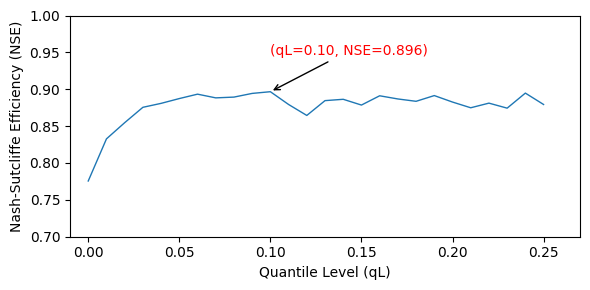

In [ ]:
# Given quantile levels
quantile_levels = np.arange(0, 0.251, 0.01)
n = len(quantile_levels)

# Find the index of the maximum NSE value
max_idx = np.argmax(nse_values)
max_value = nse_values[max_idx]
max_quantile = quantile_levels[max_idx]

# Plot NSE results with an arrow and the text NSE=max_value
plt.figure(figsize=(6, 3))
plt.plot(quantile_levels, nse_values[:n], linestyle='-', linewidth=1)  # Reduce linewidth for a finer curve
plt.xlabel('Quantile Level (qL)')
plt.ylabel('Nash-Sutcliffe Efficiency (NSE)')
# plt.grid()
plt.xticks(np.arange(0, 0.5, 0.05))  # Adjust x-axis ticks as needed
plt.ylim(0.7, 1)  # Adjust y-axis limits as needed
plt.xlim(-0.01, 0.27)   # Limit x-axis to 0.27

# Add an arrow with the text NSE=max_value and the quantile level
plt.annotate(f'(qL={max_quantile:.2f}, NSE={max_value:.3f})',
             xy=(max_quantile, max_value),
             xytext=(max_quantile, max_value + 0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"),
             fontsize=10, color='red')

# Use tight_layout to avoid overlapping
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("range2.png", format='png', dpi=500)

# Download the file
files.download("range2.png")

plt.show()


In [ ]:
# Use the model after saving
q_level = q_best

data_train = pd.DataFrame({
    'mean_HyMoLAP': mean_trajectory[:-1],
    # 'var_HyMoLAP': var_trajectory[:-1],
    'diff_HyMoLAP': quantile_results[q_level]['diff'][:-1],
    # 'mode_HyMoLAP': mode_trajectory[:-1],
    'min_HyMoLAP': quantile_results[q_level]['min_trajectory'][:-1],
    'max_HyMoLAP': quantile_results[q_level]['max_trajectory'][:-1],
    'target': discharge[1:]
})

# Create the DataFrame for validation (test)
data_test = pd.DataFrame({
    'mean_HyMoLAP': mean_trajectory1[:-1],  # Use the same column names
    # 'var_HyMoLAP': var_trajectory1[:-1],
    'diff_HyMoLAP': quantile_results1[q_level]['diff1'][:-1],
    # 'mode_HyMoLAP': mode_trajectory1[:-1],
    'min_HyMoLAP': quantile_results1[q_level]['min_trajectory1'][:-1],
    'max_HyMoLAP': quantile_results1[q_level]['max_trajectory1'][:-1],
    'target': discharge1[1:]
})

# Concatenate the two DataFrames (calibration + validation)
data = pd.concat([data_train, data_test], ignore_index=True)

# WAVELET TRANSFORM
# Exclude the last column ('target')
columns_to_transform = data.columns[:-1]  # All columns except the last one
data_transformed = data[columns_to_transform].apply(lambda x: wavelet_transform(x, wavelet='db2', level=3), axis=0)

# Reattach the 'target' column without transformation
data_transformed['target'] = data['target']

# Retain column names
data_transformed = pd.DataFrame(data_transformed, columns=data.columns)

# Convert to pd.DataFrame
data = pd.DataFrame(data_transformed)

# Include look_back
look_back = 2
horizon = 1
data_Xy = history_and_horizon_sequencing(data, look_back, horizon, target='target')
data_Xy.dropna(inplace=True)

# Split data
train_X, train_y, test_X, test_y = split_train_test(data_Xy.values, n_train_hours=1460)

# Normalize features
values = data_Xy.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Create train/test datasets from scaled data
scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values)

# Make a prediction: Train
gru_scaled_yhat = loaded_model.predict(scaled_train_X)
# Compute performance
inv_yhat1 = invert_scaling(scaled_train_X, gru_scaled_yhat)

# Make a prediction: Test
scaled_stacked_gru_yhat = loaded_model.predict(scaled_test_X)
# Compute performance
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_gru_yhat)


Plots for validation

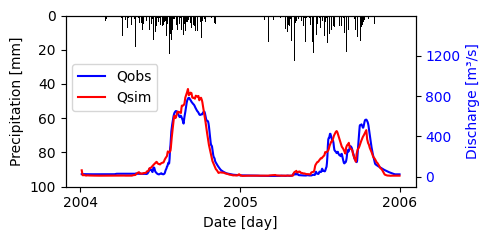

In [ ]:
# Generate the date range
time1 = np.datetime64('2004-01-04')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')  # Daily date range

fig, ax1 = plt.subplots(figsize=(5., 2.5))

# Plot precipitation (plui1) as bars on ax1
ax1.bar(time, plui1[3:], color='black')

# Format the x-axis to display only the start of each year
ax1.xaxis.set_major_locator(mdates.YearLocator())  # One label per year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Date format 'YYYY'

# Align the date labels horizontally (no rotation)
plt.xticks(rotation=0)

# Label for the x-axis
ax1.set_xlabel('Date [day]')

# Parameters for the y-axis (precipitation)
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis for discharge (Qobs)
ax2 = ax1.twinx()
ax2.plot(time, discharge1[3:], 'b', label='Qobs')  # Plot observed discharge in blue

# Plot the mean trajectories (Qsim)
ax2.plot(time, inv_yhat, 'red', label='Qsim')  # Plot simulated discharge in red

# Parameters for the y-axis (discharge)
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-100, 1600)
ax2.set_yticks(np.arange(0, 1600, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.14, 0.75))

# Use tight_layout to avoid overlapping elements
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("sto_hyb_wgru2.jpeg", format='jpeg', dpi=500)

# Optional: Download the file
# files.download("sto_hyb_wgru2.jpeg")

# Display the plot
plt.show()


In [ ]:
# Create a DataFrame to save the mean trajectory into an Excel file
df_mean_trajectory = pd.DataFrame({'Mean_Trajectory': inv_yhat})

# Save the DataFrame to an Excel file
df_mean_trajectory.to_excel('Sto_wgru.xlsx', index=False)

print("La trajectoire moyenne a été enregistrée dans 'Sto_wgru.xlsx'.")

# Download the file in Google Colab
files.download('Sto_wgru.xlsx')

La trajectoire moyenne a été enregistrée dans 'Sto_wgru.xlsx'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

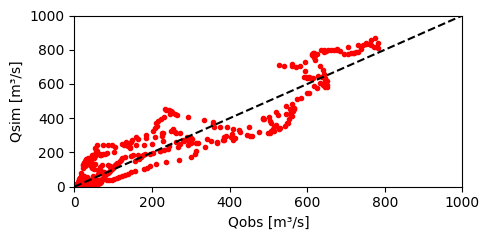

In [ ]:
# Scatter plot of observed (Qobs) vs simulated (Qsim) values
plt.figure(figsize=(5, 2.5))
plt.scatter(discharge1[3:], inv_yhat, color='red', marker='.')  # Scatter plot of the values
plt.xlabel('Qobs [m³/s]')  # Label for the x-axis (observed discharge)
plt.ylabel('Qsim [m³/s]')  # Label for the y-axis (simulated discharge)

# Adjust the x and y-axis limits based on the data
plt.xlim(0, 1000)
plt.ylim(0, 1000)

# Add a reference line y=x (the perfect fit line)
plt.plot([0, 1000], [0, 1000], color='black', linestyle='--')

# Use tight_layout to avoid label clipping issues
plt.tight_layout()

# Save the plot as a .jpeg file before displaying it
plt.savefig("sca_sto_hyb_wgru2.jpeg", format='jpeg', dpi=500)

# Download the file to your laptop
files.download("sca_sto_hyb_wgru2.jpeg")

# Now display the plot
plt.show()
